In [13]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data


In [15]:
train_df = pd.read_csv(r'C:\Users\indra\Downloads\2243_9243_bundle_archive\fashion-mnist_train.csv')
test_df = pd.read_csv(r'C:\Users\indra\Downloads\2243_9243_bundle_archive\fashion-mnist_test.csv')

train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_data = np.array(train_df, dtype='float32')
test_data = np.array(test_df, dtype='float32')

x_train = train_data[:, 1:] / 255
y_train = train_data[:, 0]

x_test = test_data[:, 1:] / 255
y_test = test_data[:, 0]

In [17]:
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train, test_size=0.2, random_state=12345,
)

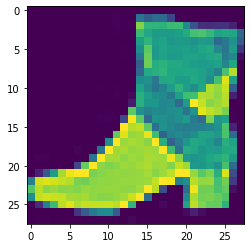

In [52]:
image = x_train[561, :].reshape((28, 28))

plt.imshow(image)
plt.show()


In [19]:
im_rows = 28
im_cols = 28
batch_size = 512
im_shape = (im_rows, im_cols, 1)

x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_validate = x_validate.reshape(x_validate.shape[0], *im_shape)

print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('x_validate shape: {}'.format(x_validate.shape))

x_train shape: (48000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
x_validate shape: (12000, 28, 28, 1)


In [22]:
cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=im_shape),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

In [23]:
tensorboard = TensorBoard(
    log_dir=r'logs\{}'.format('cnn_1layer'),
    write_graph=True,
    write_grads=True,
    histogram_freq=1,
    write_images=True,
)

cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [24]:
cnn_model.fit(
    x_train, y_train, batch_size=batch_size,
    epochs=10, verbose=1,
    validation_data=(x_validate, y_validate),
    callbacks=[tensorboard]
)

Train on 48000 samples, validate on 12000 samples




Epoch 1/10
48000/48000 [==============================] - 14s 289us/step - loss: 0.7749 - accuracy: 0.7349 - val_loss: 0.4703 - val_accuracy: 0.8322

Epoch 2/10
48000/48000 [==============================] - 14s 286us/step - loss: 0.4331 - accuracy: 0.8468 - val_loss: 0.4055 - val_accuracy: 0.8575
Epoch 3/10
48000/48000 [==============================] - 16s 332us/step - loss: 0.3808 - accuracy: 0.8649 - val_loss: 0.3610 - val_accuracy: 0.8729
Epoch 4/10
48000/48000 [==============================] - 14s 283us/step - loss: 0.3490 - accuracy: 0.8774 - val_loss: 0.3337 - val_accuracy: 0.8832
Epoch 5/10
48000/48000 [==============================] - 14s 284us/step - loss: 0.3267 - accuracy: 0.8849 - val_loss: 0.3143 - val_accuracy: 0.8903
Epoch 6/10
48000/48000 [==============================] - 18s 371us/step - loss: 0.3151 - accuracy: 0.8896 - val_loss: 0.3105 - val_accuracy: 0.8909
Epoch 7/10
48000/48000 [===========================

In [25]:
score = cnn_model.evaluate(x_test, y_test, verbose=0)

print('test loss: {:.4f}'.format(score[0]))
print(' test acc: {:.4f}'.format(score[1]))


test loss: 0.2766
 test acc: 0.9024


In [27]:
test_data = np.array(pd.read_csv(r'C:\Users\indra\Downloads\2243_9243_bundle_archive\fashion-mnist_test.csv'), dtype='float32')

embed_count = 1600
x_test = test_data[:embed_count, 1:] / 255
y_test = test_data[:embed_count, 0]

logdir = r'C:\Users\indra\Fashion_MNIST\logdir' 

In [29]:
summary_writer = tf.summary.FileWriter(logdir)

embedding_var = tf.Variable(x_test, name='fmnist_embedding')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

embedding.metadata_path = os.path.join(logdir, 'metadata.tsv')
embedding.sprite.image_path = os.path.join(logdir, 'sprite.png')
embedding.sprite.single_image_dim.extend([28, 28])

projector.visualize_embeddings(summary_writer, config)

In [30]:
with tf.Session() as sesh:
    sesh.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sesh, os.path.join(logdir, 'model.ckpt'))

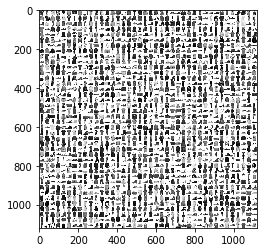

In [31]:
rows = 28
cols = 28

label = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat',
          'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boot']

sprite_dim = int(np.sqrt(x_test.shape[0]))

sprite_image = np.ones((cols * sprite_dim, rows * sprite_dim))

index = 0
labels = []
for i in range(sprite_dim):
    for j in range(sprite_dim):
        
        labels.append(label[int(y_test[index])])
        
        sprite_image[
            i * cols: (i + 1) * cols,
            j * rows: (j + 1) * rows
        ] = x_test[index].reshape(28, 28) * -1 + 1
        
        index += 1
        
with open(embedding.metadata_path, 'w') as meta:
    meta.write('Index\tLabel\n')
    for index, label in enumerate(labels):
        meta.write('{}\t{}\n'.format(index, label))
        
plt.imsave(embedding.sprite.image_path, sprite_image, cmap='gray')
plt.imshow(sprite_image, cmap='gray')
plt.show()

In [32]:
name = '1_Layer'
cnn_model_1 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=im_shape, name='Conv2D-1'),
    MaxPooling2D(pool_size=2, name='MaxPool'),
    Dropout(0.2, name='Dropout'),
    Flatten(name='flatten'),
    Dense(32, activation='relu', name='Dense'),
    Dense(10, activation='softmax', name='Output')
], name=name)

name = '2_Layer'
cnn_model_2 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=im_shape, name='Conv2D-1'),
    MaxPooling2D(pool_size=2, name='MaxPool'),
    Dropout(0.2, name='Dropout-1'),
    Conv2D(64, kernel_size=3, activation='relu', name='Conv2D-2'),
    Dropout(0.25, name='Dropout-2'),
    Flatten(name='flatten'),
    Dense(64, activation='relu', name='Dense'),
    Dense(10, activation='softmax', name='Output')
], name=name)

name='3_layer'
cnn_model_3 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', 
           input_shape=im_shape, kernel_initializer='he_normal', name='Conv2D-1'),
    MaxPooling2D(pool_size=2, name='MaxPool'),
    Dropout(0.25, name='Dropout-1'),
    Conv2D(64, kernel_size=3, activation='relu', name='Conv2D-2'),
    Dropout(0.25, name='Dropout-2'),
    Conv2D(128, kernel_size=3, activation='relu', name='Conv2D-3'),
    Dropout(0.4, name='Dropout-3'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='Dense'),
    Dropout(0.4, name='Dropout'),
    Dense(10, activation='softmax', name='Output')
], name=name)

cnn_models = [cnn_model_1, cnn_model_2, cnn_model_3]

In [33]:
for model in cnn_models:
    model.summary()


Model: "1_Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D-1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
MaxPool (MaxPooling2D)       (None, 13, 13, 32)        0         
_________________________________________________________________
Dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
Dense (Dense)                (None, 32)                173088    
_________________________________________________________________
Output (Dense)               (None, 10)                330       
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
_____________________________________________________

In [9]:
history_dict = {}

for model in cnn_models:
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=50, verbose=1,
        validation_data=(x_validate, y_validate)
    )
    
    history_dict[model.name] = history


Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 22s 461us/step - loss: 0.7360 - accuracy: 0.7519 - val_loss: 0.4680 - val_accuracy: 0.8372
Epoch 2/50
48000/48000 [==============================] - 21s 446us/step - loss: 0.4424 - accuracy: 0.8438 - val_loss: 0.4025 - val_accuracy: 0.8594
Epoch 3/50
48000/48000 [==============================] - 21s 445us/step - loss: 0.3882 - accuracy: 0.8631 - val_loss: 0.3679 - val_accuracy: 0.8712
Epoch 4/50
48000/48000 [==============================] - 21s 446us/step - loss: 0.3571 - accuracy: 0.8748 - val_loss: 0.3458 - val_accuracy: 0.8778
Epoch 5/50
48000/48000 [==============================] - 27s 570us/step - loss: 0.3395 - accuracy: 0.8799 - val_loss: 0.3264 - val_accuracy: 0.8864
Epoch 6/50
48000/48000 [==============================] - 25s 522us/step - loss: 0.3199 - accuracy: 0.8884 - val_loss: 0.3100 - val_accuracy: 0.8932
Epoch 7/50
48000/48000 [==============================]

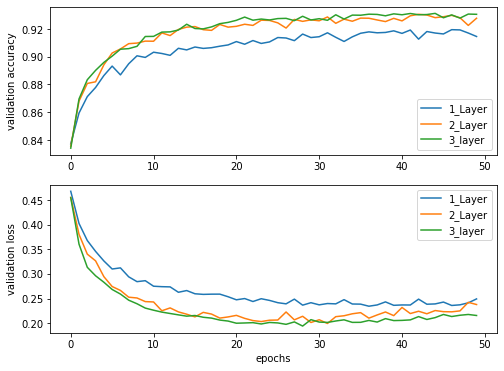

In [34]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for history in history_dict:
    val_accuracy = history_dict[history].history['val_accuracy']
    val_loss = history_dict[history].history['val_loss']
    ax1.plot(val_accuracy, label=history)
    ax2.plot(val_loss, label=history)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()
